TensorFlow Version: 2.18.0
Num GPUs Available: 2
Number of GPUs in strategy: 2
Found 3652 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training class distribution: [ 939 2713]
Validation class distribution: [ 402 1162]
Epoch 1/70


I0000 00:00:1746531146.823734     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746531146.823762     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


115/115 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8105 - loss: 11.4369 - precision: 0.9441 - recall: 0.7895 - val_accuracy: 0.7481 - val_loss: 11.2036 - val_precision: 0.7481 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 105s 897ms/step - accuracy: 0.9153 - loss: 9.4252 - precision: 0.9790 - recall: 0.9086 - val_accuracy: 0.7532 - val_loss: 10.5733 - val_precision: 0.7532 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 101s 852ms/step - accuracy: 0.9298 - loss: 7.8131 - precision: 0.9810 - recall: 0.9226 - val_accuracy: 0.7468 - val_loss: 9.6490 - val_precision: 0.7468 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 4/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 101s 855ms/step - accuracy: 0.9273 - loss: 6.5019 - precision: 0.9845 - recall: 0.9171 - val_accuracy: 0.7366 - val_loss: 8.3233 - val_precision: 0.7366 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 5/70
115/115 ━━━━━━━━━━━━━━━━━━━━ 105

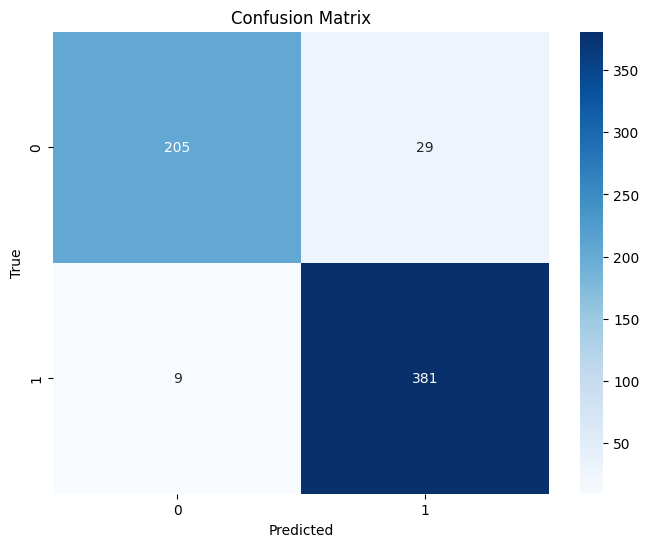

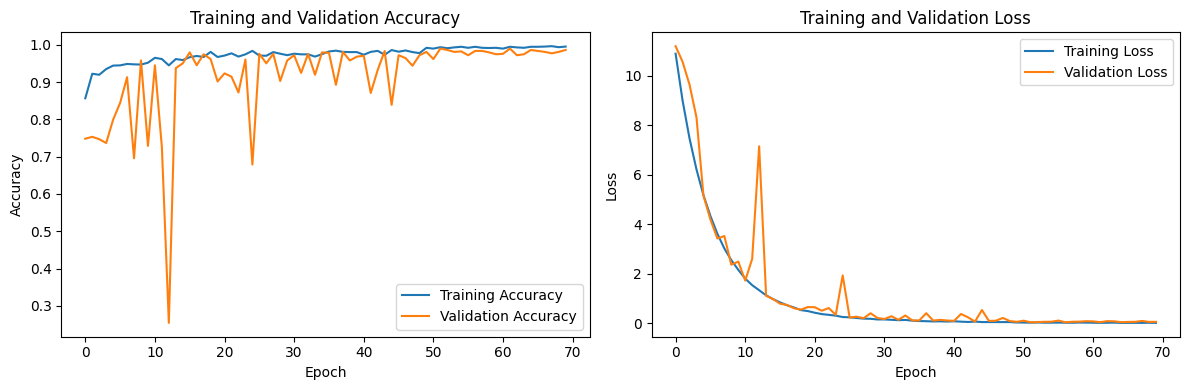


Classification Report for Test Set:
              precision    recall  f1-score   support

      NORMAL       0.96      0.88      0.92       234
   PNEUMONIA       0.93      0.98      0.95       390

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.93       624
weighted avg       0.94      0.94      0.94       624



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress CUDA warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPooling2D, GlobalAveragePooling2D, Conv2D, Dropout, BatchNormalization, Activation, Input, Multiply, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import warnings

# Add warrnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras')

# Set random seeds for reproducibility (getting the same result on different runs)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Print TensorFlow version and GPU availability 
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Initialize MirroredStrategy for multi-GPU training (Using kaggle GPU T4 X2)
strategy = tf.distribute.MirroredStrategy()
print("Number of GPUs in strategy:", strategy.num_replicas_in_sync)

# Define paths to the dataset directories in Kaggle
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Verify dataset directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found: {test_dir}")

# Build everything within the strategy scope
with strategy.scope():
    # Refined data augmentation for training and validation (can be a bit severe for normal training)
    train_val_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.3
    )

    # Load training data (32 batch size is good for T4 vram 16GB per GPU)
    training_data = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        subset='training',
        seed=SEED  # Ensure consistent split
    )

    # Load validation data
    validation_data = train_val_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        subset='validation',
        seed=SEED  # Ensure consistent split
    )

    # Test data generator (no augmentation, just rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Load test data
    testing_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        color_mode='grayscale',
        class_mode='binary',
        batch_size=32,
        shuffle=False,
        seed=SEED  # Ensure consistent order
    )

    # Print class indices and validation class distribution
    print("Class indices:", training_data.class_indices)
    print("Training class distribution:", np.bincount(training_data.classes))
    print("Validation class distribution:", np.bincount(validation_data.classes))

    # Adjusted class weights based on class distribution so model won't bias to class 1
    class_weight_dict = {0: 1.5, 1: 0.5}

    # Squeeze-and-Excitation (SE) Block better detection for pneumonia hard patterns 
    def se_block(input_tensor, reduction=16):
        channels = input_tensor.shape[-1]
        x = GlobalAveragePooling2D()(input_tensor)
        x = Dense(channels // reduction, activation='relu')(x)
        x = Dense(channels, activation='sigmoid')(x)
        x = Multiply()([input_tensor, x[:, None, None, :]])
        return x

    # Enhanced CNN with skip connections (It's considered too deep and a complex for normal training and can waste resources 
    # and time for almost no development in results but suitable for medical problems)
    inputs = Input(shape=(224, 224, 1))

    # Block 1
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 2
    identity = x
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    identity = Conv2D(128, (1, 1), padding='same')(identity)
    x = Add()([x, identity])
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 3
    identity = x
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    identity = Conv2D(256, (1, 1), padding='same')(identity)
    x = Add()([x, identity])
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 4
    identity = x
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    identity = Conv2D(512, (1, 1), padding='same')(identity)
    x = Add()([x, identity])
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 5
    identity = x
    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1024, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    identity = Conv2D(1024, (1, 1), padding='same')(identity)
    x = Add()([x, identity])
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Block 6
    identity = x
    x = Conv2D(2048, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(2048, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    identity = Conv2D(2048, (1, 1), padding='same')(identity)
    x = Add()([x, identity])
    x = Activation('relu')(x)
    x = se_block(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Compile the model with binary cross-entropy
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.00005),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000005)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    training_data,
    epochs=70,
    validation_data=validation_data,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Load the best model
model.load_weights('/kaggle/working/best_model.keras')

# Evaluate the model on validation data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_data)
print(f"Validation Accuracy After Restoring Best Weights: {val_accuracy:.4f}, Loss: {val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

# Predict on test data
predictions = model.predict(testing_data)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = testing_data.classes

# Generate and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# Plot accuracy and loss curves
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/accuracy_loss_curves.png')
plt.show()

# Generate and print classification report for test set
print("\nClassification Report for Test Set:")
print(classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA']))